# Install dependencies

In [1]:
%pip install --quiet --upgrade git+https://github.com/mozilla-ai/osm-ai-helper.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.2/915.2 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Setup Secrets

You need to set the following secrets in the notebook.



In [3]:
import os

from google.colab import userdata

os.environ["MAPBOX_TOKEN"] = userdata.get("MAPBOX_TOKEN")
os.environ["OSM_CLIENT_ID"] = userdata.get("OSM_CLIENT_ID")
os.environ["OSM_CLIENT_SECRET"] = userdata.get("OSM_CLIENT_SECRET")

# Download Trained Model

You can check the [Create Dataset](https://colab.research.google.com/github/mozilla-ai//osm-ai-helper/blob/main/demo/create_dataset.ipyn) and [Finetune Model](https://colab.research.google.com/github/mozilla-ai//osm-ai-helper/blob/main/demo/finetune_model.ipynb) notebooks to learn how to train your own model.

In [4]:
from huggingface_hub import hf_hub_download

In [5]:
hf_hub_download(
    "daavoo/yolo-osm-pool-detector",
    filename="model.pt",
    repo_type="model",
    local_dir="models",
)

model.pt:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

'models/model.pt'

# Run Inference

In [6]:
# @title Click on the map and copy-paste the latitude and longitude

import folium
from branca.element import MacroElement
from jinja2 import Template
from IPython.display import display


class LatLngPopup(MacroElement):
    _template = Template(
        """
            {% macro script(this, kwargs) %}
                var {{this.get_name()}} = L.popup();
                function latLngPop(e) {
                    {{this.get_name()}}
                        .setLatLng(e.latlng)
                        .setContent(e.latlng.lat.toFixed(4) + ", " + e.latlng.lng.toFixed(4))
                        .openOn({{this._parent.get_name()}});
                    }
                {{this._parent.get_name()}}.on('click', latLngPop);
            {% endmacro %}
            """
    )

    def __init__(self):
        super().__init__()
        self._name = "LatLngPopup"


m = folium.Map(location=[42.2489, -8.5117], zoom_start=11, tiles="OpenStreetMap")

m.add_child(LatLngPopup())

# 3. Display the map in Colab
display(m)

In [13]:
# Paste the copied values here
LAT, LON = 42.2848, -8.8207

# Run Inference

In [14]:
from osm_ai_helper.run_inference import run_inference

output_path, existing, new, missing = run_inference(
    "models/model.pt",
    output_dir="results",
    lat_lon=(LAT, LON),
)

2025-02-19 10:19:48.342 | INFO     | osm_ai_helper.run_inference:run_inference:52 - Downloading elements for leisure=swimming_pool in (42.2834050474808, -8.823394775390625, 42.28645296292091, -8.81927490234375)
2025-02-19 10:19:49.131 | INFO     | osm_ai_helper.run_inference:run_inference:55 - Found 5 elements
2025-02-19 10:19:49.132 | INFO     | osm_ai_helper.run_inference:run_inference:57 - Downloading all tiles within (42.2834050474808, -8.823394775390625, 42.28645296292091, -8.81927490234375)
2025-02-19 10:19:55.298 | INFO     | osm_ai_helper.run_inference:run_inference:64 - Predicting on stacked image
2025-02-19 10:19:55.299 | DEBUG    | osm_ai_helper.utils.inference:tile_prediction:90 - Predicting (0, 0, 512, 512)
2025-02-19 10:19:55.856 | DEBUG    | osm_ai_helper.utils.inference:tile_prediction:90 - Predicting (0, 448, 512, 960)
2025-02-19 10:19:56.056 | DEBUG    | osm_ai_helper.utils.inference:tile_prediction:90 - Predicting (0, 896, 512, 1408)
2025-02-19 10:19:56.230 | DEBUG  

# Manually Filter results

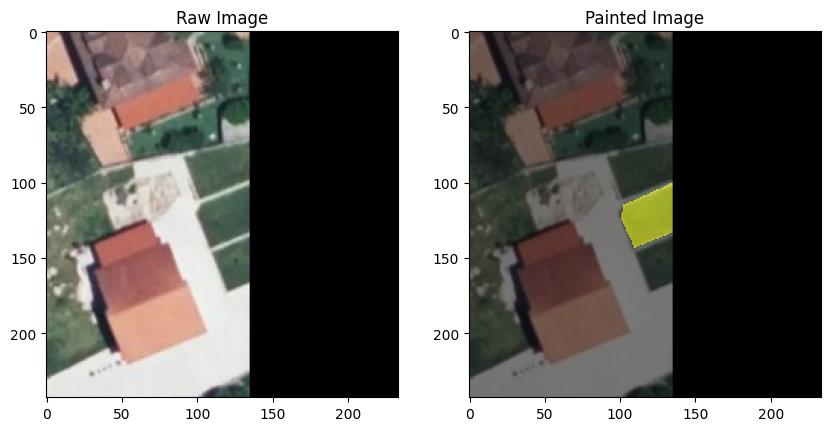

Keep image? (Y/N): N
Images moved to results/18_42.2834050474808_-8.823394775390625_42.28645296292091_-8.81927490234375/discard


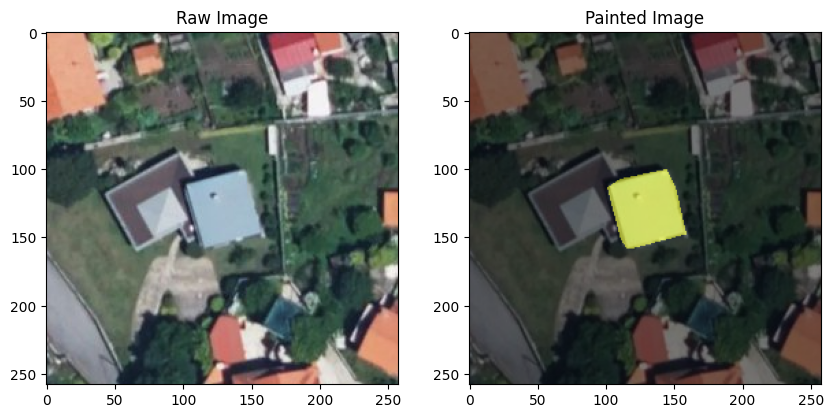

Keep image? (Y/N): N
Images moved to results/18_42.2834050474808_-8.823394775390625_42.28645296292091_-8.81927490234375/discard


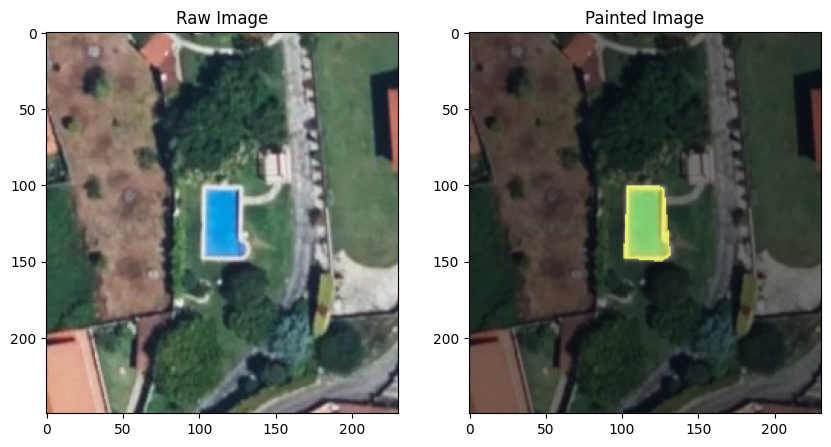

Keep image? (Y/N): Y
Images moved to results/18_42.2834050474808_-8.823394775390625_42.28645296292091_-8.81927490234375/keep


In [15]:
import shutil
import time
from pathlib import Path

from matplotlib import pyplot as plt

for new_polygon in Path(output_path).glob("*.json"):
    raw_image = new_polygon.with_suffix(".png")
    painted_image = f"{new_polygon.parent}/{new_polygon.stem}_painted.png"

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Assuming raw_image_path and painted_image_path are image file paths
    axes[0].imshow(plt.imread(raw_image))
    axes[0].set_title("Raw Image")

    axes[1].imshow(plt.imread(painted_image))
    axes[1].set_title("Painted Image")

    plt.show()
    time.sleep(1.5)

    user_input = input("Keep image? (Y/N): ")

    if user_input.upper() == "Y":
        keep_folder = output_path / "keep"
        keep_folder.mkdir(parents=True, exist_ok=True)
        shutil.move(new_polygon, keep_folder / new_polygon.name)
        print(f"Images moved to {keep_folder}")
    else:
        discard_folder = output_path / "discard"
        discard_folder.mkdir(parents=True, exist_ok=True)
        shutil.move(new_polygon, discard_folder / new_polygon.name)
        print(f"Images moved to {discard_folder}")

# Upload Results

In [ ]:
from osm_ai_helper.upload_osm import upload_osm

In [ ]:
changeset = upload_osm(
    output_path / "keep", os.environ["OSM_CLIENT_ID"], os.environ["OSM_CLIENT_SECRET"]
)

2025-02-19 10:20:31.996 | INFO     | osm_ai_helper.upload_osm:load_token:36 - Token loaded from /tmp/osm_token.json
2025-02-19 10:20:31.997 | INFO     | osm_ai_helper.upload_osm:ensure_authorized_session:75 - Token exists, attempting to use it.
2025-02-19 10:20:32.634 | INFO     | osm_ai_helper.upload_osm:open_changeset:112 - CREATE: <Response [200]>, b'162694284'
2025-02-19 10:20:32.965 | INFO     | osm_ai_helper.upload_osm:upload_polygon:161 - UPLOAD: <Response [200]>, b'<?xml version="1.0" encoding="UTF-8"?>\n<diffResult version="0.6" generator="openstreetmap-cgimap 2.0.1 (3288087 spike-08.openstreetmap.org)" copyright="OpenStreetMap and contributors" attribution="http://www.openstreetmap.org/copyright" license="http://opendatacommons.org/licenses/odbl/1-0/">\n <node old_id="-1" new_id="12600349038" new_version="1"/>\n <node old_id="-2" new_id="12600349039" new_version="1"/>\n <node old_id="-3" new_id="12600349040" new_version="1"/>\n <node old_id="-4" new_id="12600349041" new_versi

In [ ]:
print(f"Changeset created: https://www.openstreetmap.org/changeset/{changeset}")